## Testing simple truncator

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
import pandas
from sklearn.metrics import mean_squared_error
from rep_ef.estimators import EventFilterRegressor
import cPickle
from six import BytesIO

In [3]:
def load_h5(name):
    print "reading from",name
    h5f = h5py.File(name,'r')
    labels = h5f['labels'][:]
    qids = h5f['qids'][:]
    features = h5f['features'][:]
    h5f.close()
    print "done"
    sorter = numpy.argsort(qids)
    return features[sorter], qids[sorter], labels[sorter]

In [4]:
Xtr,Qtr,Ytr = load_h5("../data/MSLR/mslr_train")
Xts,Qts,Yts = load_h5("../data/MSLR/mslr_test")

reading from ../data/MSLR/mslr_train
done
reading from ../data/MSLR/mslr_test
done


In [5]:
print len(Xtr), len(Xts)

723412 241521


In [6]:
# ef = EventFilterRegressor(iterations=10000, connection='test_connection', dataset_name='letor-{random}')
# ef.fit(Xtr, Ytr)

In [7]:
# import cPickle
# with open('../data/MSLR10k_ef.mx', 'w') as f:
#     cPickle.dump(ef.formula_mx, f)

In [8]:
import cPickle
with open('../data/MSLR10k_ef.mx', 'r') as f:
    formula_mx = cPickle.load(f)

In [9]:
from _matrixnetapplier import MatrixnetClassifier
from StringIO import StringIO

In [10]:
mn = MatrixnetClassifier(StringIO(formula_mx))

In [11]:
mean_squared_error(Yts, mn.apply(Xts))

0.55456890206334308

In [12]:
sys.path.insert(0, '..')
from pruning import greedy, utils, _matrixnetapplier

In [13]:
from hep_ml.losses import MSELossFunction, AbstractLossFunction

In [14]:
Xtr = numpy.array(Xtr, dtype='float32', order='F')
Xts = numpy.array(Xts, dtype='float32', order='F')
Wtr = Ytr * 0 + 1.
Wts = Yts * 0 + 1.

## Training many classifiers

In [ ]:
from collections import OrderedDict
trained_formulas = OrderedDict()

In [ ]:
for reg in [0.]:
    for learning_rate in [0.1,]:
        for nn_steps in [0, 1, 2]:
            pruner = greedy.NesterovPruner(loss_function=MSELossFunction(), learning_rate=learning_rate,
                                           n_nesterov_steps=nn_steps, iterations=200, n_kept_best=5, 
                                           regularization=reg)
            trained_formulas['{} {} {}'.format(reg, learning_rate, nn_steps)] = \
                pruner.prune(formula_mx, Xtr, Ytr, Wtr)
            with open('../data/pickled_trunced_rankers.pkl', 'w') as f:
                cPickle.dump(trained_formulas, f)
            print 'done'

## Loading result

In [ ]:
from collections import OrderedDict
with open('../data/pickled_trunced_rankers.pkl', 'r') as f:
    trained_formulas = cPickle.load(f)

# Testing rankers

### test predictions

In [ ]:
minimals = OrderedDict()
for name, clf in trained_formulas.items():
    values = []
    for pred in clf.staged_decision_function(Xts):
        values.append(mean_squared_error(Yts, pred))
    print name, len(values), min(values)
    minimals[name] = min(values)

### train predictions

In [ ]:
minimals = OrderedDict()
for name, clf in trained_formulas.items():
    values = []
    for pred in clf.staged_decision_function(Xtr):
        values.append(mean_squared_error(Ytr, pred))
    print name, len(values), min(values)
    minimals[name] = min(values)

In [ ]:
from itertools import islice
def plot_mse_curves(clf, step=5, stop=None):
    mses_ts = []
    for p in islice(clf.staged_decision_function(Xts), None, stop, step):
        mses_ts.append(mean_squared_error(Yts, p))
    mses_tr = []
    for p in islice(clf.staged_decision_function(Xtr), None, stop, step):
        mses_tr.append(mean_squared_error(Ytr, p))
    plot(mses_ts, label='test')
    plot(mses_tr, label='train')

    return mses_tr, mses_ts

3000 0.1 0


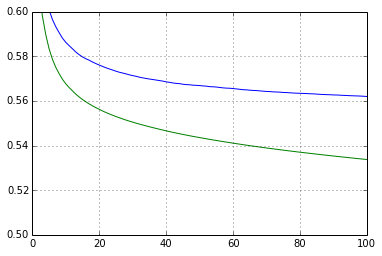

3000 0.1 1


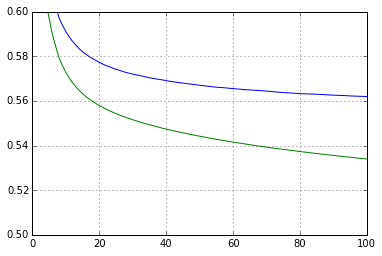

3000 0.1 2


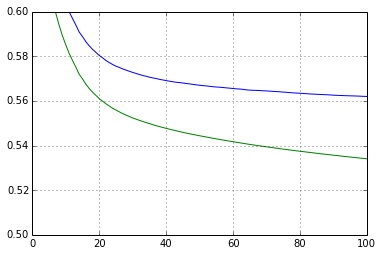

3000 0.2 0


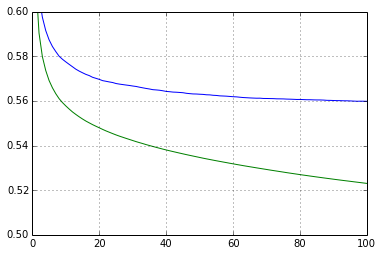

3000 0.2 1


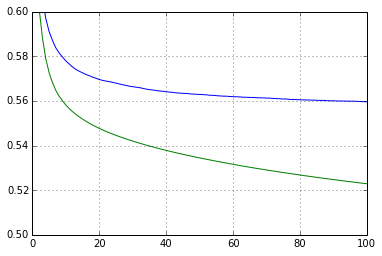

3000 0.2 2


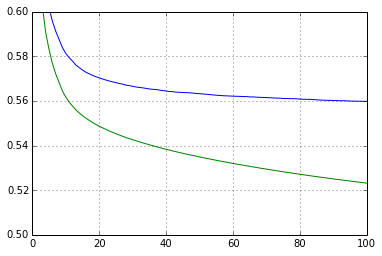

3000 0.3 0


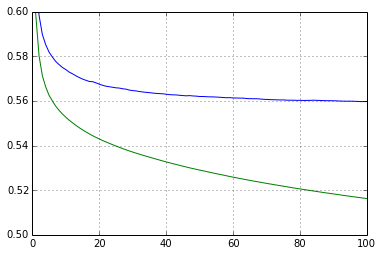

3000 0.3 1


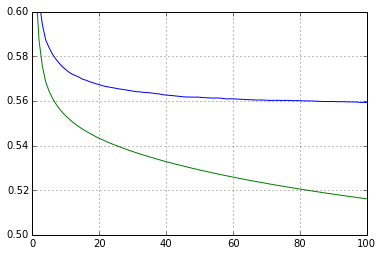

3000 0.3 2


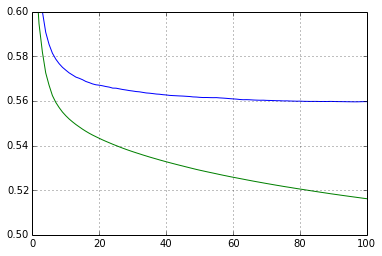

In [25]:
for name, clf in trained_formulas.items():
    mses_ef = plot_mse_curves(clf, step=5)
    ylim(0.5, 0.6), grid()
    print name
    show()

In [24]:
trained_formulas.keys()

['3000 0.1 0',
 '3000 0.1 1',
 '3000 0.1 2',
 '3000 0.2 0',
 '3000 0.2 1',
 '3000 0.2 2',
 '3000 0.3 0',
 '3000 0.3 1',
 '3000 0.3 2']

In [27]:
pruner.__dict__

{'iterations': 500,
 'learning_rate': 0.3,
 'loss_function': MSELossFunction(regularization=5.0),
 'n_candidates': 100,
 'n_kept_best': 5,
 'n_nesterov_steps': 2,
 'regularization': 3000,
 'verbose': False}